Name(s): Alan Tran and John Smith

# HW 6: Q-Learning and Association Analysis

## Part 1: Q-Learning

For the first part of this assignment, you'll code an ML agent that uses Q-Learning to learn how to play Snake.

<img src="snake_game.jpg" width="300"/>


If you are not familiar with the game of Snake, read about how the game is played, and even play it yourself, [here](https://www.coolmathgames.com/blog/how-to-play-snake-mastering-a-classic). 

Once you understand how to play the game, continue with the assignment!

#### Imports

In [433]:
# you will need pygame installed
# !pip install pygame

In [434]:
import pygame
import random
import numpy as np

import pickle as pkl
import itertools

# the environment is provided in game_loop.py
from game_loop import *

### Game States
For Q-Learning, the agent needs to keep a Q-Table of game states. To keep the number of possible game states manageable, we will define the game state as a combination of:
* Horizontal orientation from the food - is the food currently to the left or the right of the snake's head? (-1: left, 0: same, 1: right)
* Vertical orientation from the food - is the food currently above or below the snake's head? (-1: below, 0: same, 1: above) 
* What are in the squares adjacent to the snake's head - are there walls or snake tail in these squares? (1 indicates something is there, 0 indicates it is open)

The environment (which is in the provided `game_loop.py` file) will provide this state in the form of two tuples:
- The first tuple will contain (relative horizontal orientation to food, relative vertical orientation to food).
- The second tuple will contain the squares surrounding the snake's head in the form of (up, down, left, right) where a 1 indicates wall or tail is in that square and 0 indicates that square is open.

### Snake Agent
Below is a provided class for the SnakeAgent that will learn to play the game, using Q-Learning. 

Some methods have been provided for you - **do not change these**:
* `__init__`: The constructor sets up some constants and sets the learning parameter values. Do not change the learning parameter values for part 1 of this assignment. It also calls init_qtable to initialize the Q-Table. 
* `init_qtable`: Initializes the Q-Table. The `qtable` is implemented as a dictionary of state -> list of four Q-Values, representing the four action choices of [left, right, up, down].
* `save` and `load`: Saves the Q-Values (via pickle) so the agent can be re-loaded later via load.

There are two additional methods in the SnakeAgent class **that you will implement**. These will be called by the `game_loop.py` file.
* `act`: This method is responsible for selecting an action based on the current state.
* `update`: This where the Q-values get updated based on the agent's actions and rewards during gameplay.


### Implementation

Q1. Implement the `act` method in the SnakeAgent class.

The `act` method is responsible for selecting an action based on the current state, which is determined by the Snake's position and the relative position of the food. The agent can choose to explore randomly with a probability of epsilon or to exploit the learned Q-values to select the next action.

In this method, you should:
- Based on the current state, choose an action using an epsilon-greedy strategy
  - Explore: Select a random action (0: left, 1: right, 2: up, 3: down)
  - Exploit: Select the action with the highest Q-value for the current state
- Record the current state and action, as you'll need these later for the update method (use `self.curr_state` and `self.curr_act`)
- Return the chosen action as a string (use `self.ACTION_STRING_MAP` in the SnakeAgent class)

Q2. Implement the `update` method in the SnakeAgent class.

The `update` method is a critical part of your SnakeAgent's learning process. It's where you update the Q-values based on the agent's actions and rewards during gameplay. Follow these steps to implement the `update` function:

**Rewards**:
Positive rewards are given for favorable actions, and negative rewards are given for unfavorable ones.
- Check if the game is over using the `game_over` parameter. If it is over, give the agent a reward of -10 to indicate that the agent has lost the game.
- If the game is not over, calculate the reward as follows: 
    - If the snake got closer to the food or if it ate the food, then set the reward to +1. 
    - If the snake got farther from the food or did not eat the food, then set the reward to -1.
You can use `self.curr_dist_from_food` and the incoming parameter from the environment `dist_from_food` to help you determine this.
    
**Update the Q-value for the state-action pair**:
- With the current state and action, update the Q-value for this state-action pair using the Q-learning formula, where `max(Q(s_t_plus_1))` is the maximum Q-value for the next state:
$$
Q(s_t, a_t) = Q(s_t, a_t) + \alpha \cdot (R_t + \gamma \cdot \max_a Q(s_{t+1}, a) - Q(s_t, a_t))
$$

In [435]:
class SnakeAgent(object):
    '''
    Do not change this code, except for the 'act' and 'update' methods.
    '''
    def __init__(self, DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE):

        self.ACTION_STRING_MAP = {0: "left", 1: "right", 2: "up", 3: "down"}

        # Learning parameters - do not change these for Part 1
        self.epsilon = 0.1 # exploration rate
        self.alpha = 0.7 # learning rate
        self.gamma = 0.5 # discount factor

        # Initialize the Q-Table
        self.init_qtable()
        
        # State/Action history
        self.curr_state = None
        self.curr_act = None
        self.curr_dist_from_food = 1000

    def init_qtable(self):
        '''Initialize the qtable to all 0s'''
        self.qtable = {}
        REL_Y = [-1, 0, 1] # [below, same, above]
        REL_X = [-1, 0, 1] # [left, same, right]
        SURROUNDINGS = list(itertools.product(*[[0,1]] * 4)) # [0, 1] possibilities for surrounding block in each direction
        for y in REL_X:
            for x in REL_Y:
                for s in SURROUNDINGS:
                    self.qtable[QState((x, y), tuple(s))] = [0, 0, 0, 0] # q values for actions [left, right, up, down]

    def load(self, path="qtable.pkl"):
        return pkl.load(open(path, "rb"))

    def save(self, path="qtable.pkl"):
        pkl.dump(self.qtable, open(path, "wb"))
        
    
    '''
    Implement these methods:
    '''
    
    def act(self, state):
        self.curr_state = state
        exploit_choice = random.random()
        if (exploit_choice < self.epsilon) :
            self.curr_act = random.randint(0, 3)
        else : 
            q_values = self.qtable[state]
            self.curr_act = np.argmax(q_values)
        return self.ACTION_STRING_MAP[self.curr_act]
    
    def update(self, game_over, dist_from_food, new_state):  
        # TODO: Implement this method
        if game_over:
            reward = -10
        elif dist_from_food < self.curr_dist_from_food or dist_from_food == 0:
            # snake got closer to food or it ate the food (distance == 0)
            reward = 1
        else:
            # snake got futher or didn't eat the food
            reward = -1

        old_q = self.qtable[self.curr_state][self.curr_act]
        self.qtable[self.curr_state][self.curr_act] = old_q + self.alpha * (reward + self.gamma * max(self.qtable[new_state]) - old_q)
        
        self.curr_dist_from_food = dist_from_food

        return reward


### Game Loop
The code in this cell will kick off the game, using your SnakeAgent, and will let your agent play for the specified number of eqisodes, keeping track of the scores as your agent learns how to play. 

In [436]:
'''
Do not change the code in this cell!
(except for setting draw=False if you want to turn off the game visualization)
'''

pygame.init()

BLOCK_SIZE = 10 
DIS_WIDTH = 600
DIS_HEIGHT = 500
FRAMESPEED = 50000
NUM_EPISODES = 300

# create a SnakeAgent
agent = SnakeAgent(DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE)

game_count = 1
max_score = 0

# loop for specified number of episodes
for i in range(NUM_EPISODES):
    # use a decaying epsilon rate
    if game_count > 100:
        agent.epsilon = .01
    else:
        agent.epsilon = .3
        
    # Start the game
    # (To turn off the game visualizations, you can set draw=False)
    score = GameLoop(agent, DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, FRAMESPEED, draw=True)
    
    max_score = max(max_score, score)
    print(f"Games: {game_count}; Score: {score}; Max Score: {max_score}") # Output results of each game to console to monitor as agent is training
    game_count += 1

agent.save()
print("Save Qvals")
pygame.quit()

Games: 1; Score: 1; Max Score: 1
Games: 2; Score: 1; Max Score: 1
Games: 3; Score: 1; Max Score: 1
Games: 4; Score: 1; Max Score: 1
Games: 5; Score: 1; Max Score: 1
Games: 6; Score: 1; Max Score: 1
Games: 7; Score: 1; Max Score: 1
Games: 8; Score: 1; Max Score: 1
Games: 9; Score: 1; Max Score: 1
Games: 10; Score: 1; Max Score: 1
Games: 11; Score: 1; Max Score: 1
Games: 12; Score: 1; Max Score: 1
Games: 13; Score: 1; Max Score: 1
Games: 14; Score: 1; Max Score: 1
Games: 15; Score: 1; Max Score: 1
Games: 16; Score: 1; Max Score: 1
Games: 17; Score: 1; Max Score: 1
Games: 18; Score: 1; Max Score: 1
Games: 19; Score: 1; Max Score: 1
Games: 20; Score: 0; Max Score: 1
Games: 21; Score: 1; Max Score: 1
Games: 22; Score: 1; Max Score: 1
Games: 23; Score: 1; Max Score: 1
Games: 24; Score: 1; Max Score: 1
Games: 25; Score: 1; Max Score: 1
Games: 26; Score: 1; Max Score: 1
Games: 27; Score: 1; Max Score: 1
Games: 28; Score: 1; Max Score: 1
Games: 29; Score: 1; Max Score: 1
Games: 30; Score: 1; Ma

#### Saving and loading the trained agent
The code above above saves your trained agent. You can use the cell below to load your trained agent and run it (so you don't have to re-train it).

In [437]:
agent.load()
pygame.init()
GameLoop(agent, DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, FRAMESPEED, draw=True)
pygame.quit()

### Extra Credit (+5)
Improve the Agent's Performance. Can you get a max score above 80 within 300 episodes? 
Potential ideas: improve the state representation, change the reward function, change the hyperparameters, etc.

**Copy the SnakeAgent class from above and paste a copy of it in a new cell (you can make a new cell between the SnakeAgent class and the GameLoop cell). Make any extra credit adjustments to the copy, preserving your original SnakeAgent class so that Q1 and Q2 can be graded.**
- Write in a markdown cell what you changed and what your observations were

In [438]:
# class SnakeAgentExtraCredit(object):
#     '''
#     Do not change this code, except for the 'act' and 'update' methods.
#     '''
#     def __init__(self, DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, epsilon, alpha, gamma):

#         self.ACTION_STRING_MAP = {0: "left", 1: "right", 2: "up", 3: "down"}

#         # Learning parameters - do not change these for Part 1
    
#         self.epsilon = epsilon # exploration rate
#         self.alpha = alpha # learning rate
#         self.gamma = gamma # discount factor

#         # Initialize the Q-Table
#         self.init_qtable()
        
#         # State/Action history
#         self.curr_state = None
#         self.curr_act = None
#         self.curr_dist_from_food = 1000

#     def init_qtable(self):
#         '''Initialize the qtable to all 0s'''
#         self.qtable = {}
#         REL_Y = [-1, 0, 1] # [below, same, above]
#         REL_X = [-1, 0, 1] # [left, same, right]
#         SURROUNDINGS = list(itertools.product(*[[0,1]] * 4)) # [0, 1] possibilities for surrounding block in each direction
#         for y in REL_X:
#             for x in REL_Y:
#                 for s in SURROUNDINGS:
#                     self.qtable[QState((x, y), tuple(s))] = [0, 0, 0, 0] # q values for actions [left, right, up, down]

#     def load(self, path="qtable.pkl"):
#         return pkl.load(open(path, "rb"))

#     def save(self, path="qtable.pkl"):
#         pkl.dump(self.qtable, open(path, "wb"))
        
    
#     '''
#     Implement these methods:
#     '''
    
#     def act(self, state):
#         self.curr_state = state
#         exploit_choice = random.random()
#         if (exploit_choice < self.epsilon) :
#             self.curr_act = random.randint(0, 3)
#         else : 
#             q_values = self.qtable[state]
#             self.curr_act = np.argmax(q_values)
#         return self.ACTION_STRING_MAP[self.curr_act]
    
#     def update(self, game_over, dist_from_food, new_state):  
#         # TODO: Implement this method
#         if game_over:
#             reward = -10
#         elif dist_from_food < self.curr_dist_from_food or dist_from_food == 0:
#             # snake got closer to food or it ate the food (distance == 0)
#             reward = 1
#             if dist_from_food < 20 : 
#                 reward += 1
#         else:
#             # snake got futher or didn't eat the food
#             reward = -1
#         old_q = self.qtable[self.curr_state][self.curr_act]
#         self.qtable[self.curr_state][self.curr_act] = old_q + self.alpha * (reward + self.gamma * max(self.qtable[new_state]) - old_q)
        
#         self.curr_dist_from_food = dist_from_food

#         return reward
    


# '''
# Do not change the code in this cell!
# (except for setting draw=False if you want to turn off the game visualization)
# '''
# def run_game(agent) :
#     best_i = 0
#     game_count = 1
#     max_score = 0

#     # loop for specified number of episodes
#     for i in range(NUM_EPISODES):
#         # use a decaying epsilon rate
#         if game_count > 75:
#             agent.epsilon = .01
#         else:
#             agent.epsilon = .1
            
#         # Start the game
#         # (To turn off the game visualizations, you can set draw=False)
#         score = GameLoop(agent, DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, FRAMESPEED, draw=True)
        
#         if (score > max_score) :
#             best_i = i
#             max_score = score

#         # best_score = max(best_score, max_score)
#         print(f"Games: {game_count}; Score: {score}; Max Score: {max_score}") # Output results of each game to console to monitor as agent is training
#         game_count += 1
#     print("max score of game: ", max_score)
#     return best_i, max_score

# pygame.init()

# BLOCK_SIZE = 10 
# DIS_WIDTH = 600
# DIS_HEIGHT = 500
# FRAMESPEED = 50000
# NUM_EPISODES = 300

# # create a SnakeAgent
# # best_score = 0
# # best_eps = 0.1
# # best_alpha = 0.1
# # best_gamma = 0.1
# # for i in range(1, 10, 2) :
# #     agent = SnakeAgentExtraCredit(DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, i/10, best_alpha, best_gamma) # tuning learning parameters
# #     best_eps, run_score = run_game(agent)
# #     if (run_score > best_score) :
# #         best_score = run_score
# #         best_eps = i/10
# #         print(best_eps)
# # for i in range(1, 10, 2) :
# #     agent = SnakeAgentExtraCredit(DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, best_eps, i/10, best_gamma) # tuning learning parameters
# #     best_eps, run_score = run_game(agent)
#     # if (run_score > best_score) :
# #         best_score = run_score
# #         best_alpha = i/10
# # for i in range(1, 10, 2) :
# #     agent = SnakeAgentExtraCredit(DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, best_eps, best_alpha, i/10) # tuning learning parameters
# #     best_eps, run_score = run_game(agent)
# #     if (run_score > best_score) :
# #         best_score = run_score
# #         best_gamma = i/10

# agent = SnakeAgentExtraCredit(DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, 0.3, 0.7, 0.6) # tuning learning parameters
# best_eps, best_score = run_game(agent)
# print("BEST score: ", best_score)
# # print(f"Best eps: {best_eps} Best alpha: {best_alpha} Best gamma: {best_gamma}")
# agent.save()
# print("Save Qvals")
# pygame.quit()




## Part 2: Association Analysis

Association analysis uses machine learning to extract frequent itemsets and strong association rules from large datasets. In this assignment you'll be implementing one of the most commonly used algorithms for association rule mining - the Apriori algorithm.

The dataset (`large_retail.txt`) that we are going to use has been adapted from the [Retail Market Basket Dataset](http://fimi.ua.ac.be/data/retail.pdf). This dataset contains transaction records supplied by a Belgian retail supermarket store. Each line in the file represents a separate transaction with the item ids separated by space. The dataset has 3000 transactions and 99 different item ids.

You are also provided with a smaller dataset (`small_retail.txt`) with 9 transactions and 5 different item ids. You can test and debug your implementation on this smaller dataset.

### Apriori Algorithm from scratch

The Apriori algorithm is a classical algorithm in data mining. It is used for mining frequent itemsets and relevant association rules. In this part, you'll be implementing this algorithm for generating the itemsets that occur enough times to meet the `min_sup` threshold.

- Use the `frozenset` data structure in Python, which is similar to `set` in functionality, to represent the itemsets, because `frozenset` is an immutable (hashable) data structure. You can maintain a dictionary that maps from the itemset (a `frozenset`) to its support count.

In [439]:
# Reading the dataset from file
def load_dataset(file_name):
    with open(file_name, 'r') as f:
        content = f.readlines()
        data = [[int(x) for x in line.rstrip().split()] for line in content]
    return data

In [440]:
# Read in the small_retail dataset
small_dataset = load_dataset('small_retail.txt')
small_dataset

[[1, 2, 5],
 [2, 4],
 [2, 3],
 [1, 2, 4],
 [1, 3],
 [2, 3],
 [1, 3],
 [1, 2, 3, 5],
 [1, 2, 3]]

Q3. Implement the function `create_1_itemsets` that takes as input the entire dataset and returns a list of all the candidate 1-itemsets. For example, for `small_retail.txt` it should return:
~~~
[frozenset({1}),
 frozenset({2}),
 frozenset({3}),
 frozenset({4}),
 frozenset({5})]
 ~~~
Don't hardcode the item ids, your code should support item ids that are non-sequential. Return the list in sorted (numeric) order.

In [441]:
def create_1_itemsets(dataset):
    c1 = []
    tset = set()
    for entry in dataset:
        for item in entry:
            tset.add(item)
    tset = sorted(tset)
    for item in tset :
        c1.append(frozenset({item}))

    return c1

Q4. Implement function `filter_candidates` that takes as input the candidate itemsets, the dataset, and the minumum support count `min_sup`, and filters out candidates that don't meet the support threshold.

Return a list of all the itemsets that meet `min_sup` (as a list of frozensets) and the support count information for all of them (as a `dict`).

In [442]:
def filter_candidates(candidates, dataset, min_sup):
    retlist = []
    support_data = {}
    for candidate in candidates : # candidate is one FROZENSET
        support_data[candidate] = 0
        for entry in dataset:
            if candidate.issubset(entry) : 
                support_data[candidate] = support_data[candidate] + 1
        if (support_data[candidate] >= min_sup) :
            retlist.append(candidate)
        else : 
            del support_data[candidate]
    return retlist, support_data

Q5. Implement the function `generate_next_itemsets` that takes in frequent itemsets of size `k` and generates candidate itemsets of size `k + 1`.

Use either the F(k-1) x F(k-1) or the F(k-1) x F(1) candidate generation method, then **filter the candidate list based on the apriori principle before returning it.**

In [443]:
from itertools import combinations
# If we are dealing with F2, we need to pass in F1 twice!
def generate_next_itemsets(freq_sets, freq_1_sets=None):
    retlist = []
    all_perms = set()

    for k_item in freq_sets :
        for one_item in freq_1_sets :
            l = []
            if (k_item != one_item) :
                if len(k_item) > 1 :
                    for j in k_item : 
                        l.append(j)
                else :
                    l.append(next(iter(k_item)))

                l.append(next(iter(one_item)))
                froz = frozenset(l)
                if (len(l) == len(freq_sets[0]) + 1 and len(froz) == len(l)) :
                    all_perms.add(froz)
    if (len(freq_sets[0]) == 1) :
        return list(all_perms)

    # unpacks the candidates to get the individual items
    for candidate in all_perms :
        is_freq_subset = True
        for subset in (combinations(candidate, len(candidate) - 1)) :
            if len(subset) == len(candidate) - 1 :
                if frozenset(subset) not in freq_sets:
                    is_freq_subset = False
                    continue
        if (is_freq_subset) :
            retlist.append(candidate)
    
    return retlist

Q6. Implement the function `apriori_freq_itemsets` that takes the entire dataset as input and returns all the frequent itemsets that meet `min_sup`. Return a list of all the itemsets that meet `min_sup` (as a list of frozensets) and the support count information for all of them (as a `dict`).

In [444]:
def apriori_freq_itemsets(dataset, minsup):
    # Temp list is going to store F1, F2, ... Fk
    temp_list = []
    # Ret list will store each frequent itemset, such as F[1], F[2], F[1,2], ...
    retlist = []
    support_data = {}

    # Generate the k=1 and k=2 itemsets
    candidate1 = create_1_itemsets(dataset)
    f1, support_data = filter_candidates(candidate1, dataset, minsup)
    temp_list.append(f1)
    f2 = generate_next_itemsets(f1, f1)
    f_k, d2 = filter_candidates(f2, dataset, minsup)
    support_data = {**support_data, **d2}
    temp_list.append(f_k)
    
    while len(f_k) > 0:
        f_k = generate_next_itemsets(temp_list[-1], temp_list[0])
        f_k, d_k = filter_candidates(f_k, dataset, minsup)
        temp_list.append(f_k)
        support_data = {**support_data, **d_k}
    for i in temp_list : 
        for j in i : 
            retlist.append(j)
    return retlist, support_data

Q7. Use the provided `print_itemsets` function to display the frequent itemsets and their supports for the `large_retail.txt` dataset **with a min_support count of 300**.

For testing/debugging purposes, the output for the `small_retail.txt` dataset with `min_sup` set to 2 is:
~~~~
Sup	Freq Itemset
6	[1]
7	[2]
6	[3]
2	[4]
2	[5]
4	[1, 2]
4	[1, 3]
2	[1, 5]
4	[2, 3]
2	[2, 4]
2	[2, 5]
2	[1, 2, 3]
2	[1, 2, 5]
~~~~

In [445]:
# DO NOT CHANGE THE CODE IN THIS CELL

'''
If total_tid is not set, support count will be displayed.
If total_tid is set to the length of the dataset, support as a percentage/ratio will be displayed.
'''
def print_itemsets(support_data, total_tid=1):
    print ('\nSup\tFreq Itemset')
    #group itemsets by length
    length_dict = {}
    
    for itemset in support_data:
        #sort the itemset
        lst = (sorted(list(itemset)))
        #add it to dictionary by length
        if len(lst) not in length_dict:
            length_dict[len(lst)] = []
        length_dict[len(lst)].append(lst)

    for length in length_dict:
        lst = sorted(length_dict[length])
        for item in lst:
            if total_tid == 1: #support count
                print(str(support_data[frozenset(item)]) + '\t' + str(item))
            else: #support ratio
                print(str(round(support_data[frozenset(item)] / total_tid, 2)) + '\t' + str(item))

In [446]:
large_dataset = load_dataset('large_retail.txt')

l, d = apriori_freq_itemsets(large_dataset, 300)
print_itemsets(d)


Sup	Freq Itemset
309	[31]
420	[32]
320	[36]
771	[38]
1592	[39]
669	[41]
1396	[48]
337	[60]
329	[65]
343	[89]
420	[32, 39]
449	[38, 39]
384	[38, 48]
428	[39, 41]
982	[39, 48]
534	[41, 48]
428	[39, 41, 48]


## Part 3: Apriori Algorithm using MLXtend

#### Installation
`MLxtend` is a library that provides functionality for association rule mining. The documentation for this library is available [here](http://rasbt.github.io/mlxtend/).

In [447]:
# install the MLxtend library
# !pip install mlxtend

In [448]:
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpmax


%matplotlib inline

### Dataset
For the third part of this assignment, the data we'll use comes from a bakery called "The Bread Basket", located in the historic center of Edinburgh. The dataset contains more than 9000 transactions from the bakery. The file contains the following columns:

- Date. Categorical variable that tells us the date of the transactions (YYYY-MM-DD format). The column includes dates from 2016-10-30 to 2017-04-09.

- Time. Categorical variable that tells us the time of the transactions (HH:MM:SS format).

- Transaction. Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction.

- Item. Categorical variable with the products purchased.

In this part, you'll be running the Apriori algorithm from the MLxtend library to generate the itemsets that occur more than the `min_sup` threshold. Based on these frequent itemsets, you'll find association rules that have confidence above the `min_conf` threshold.

In [449]:
# Reading the dataset from file
def load_dataset(file_name):
    with open(file_name, 'r') as f:
        content = f.readlines()[1:]
    transactions = []
    prev_tid = -1
    for t in content:
        t = t.strip().split(',')[-2:]
        tid = t[0]
        item = t[1]
        if prev_tid != tid:
            prev_tid = tid
            transactions.append([item])
        else:
            transactions[-1].append(item)
    return transactions

In [450]:
dataset = load_dataset('BreadBasket_DMS.csv')

# ** NOTE: dataset is a 2D list (not a dataframe!) **

print("Num transactions:", len(dataset))
#Print the first 10 transactions
dataset[:10]

Num transactions: 9531


[['Bread'],
 ['Scandinavian', 'Scandinavian'],
 ['Hot chocolate', 'Jam', 'Cookies'],
 ['Muffin'],
 ['Coffee', 'Pastry', 'Bread'],
 ['Medialuna', 'Pastry', 'Muffin'],
 ['Medialuna', 'Pastry', 'Coffee', 'Tea'],
 ['Pastry', 'Bread'],
 ['Bread', 'Muffin'],
 ['Scandinavian', 'Medialuna']]

Q8. Data Cleaning: Many transactions in the dataset include the item "NONE." First, find and remove all the "NONE" items from the dataset. There are some transactions that only contain "NONE," so removing "NONE" will leave some transactions as empty lists. Remove all the empty lists as well. 

Once you have removed the NONEs, find the top 10 best-selling items in the bakery. Create a bar chart to display the total number of transactions for each of the top 10 selling items. Sort the bar chart by frequency (the top most sold item first, down to the 10th most sold item).

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Coffee'),
  Text(1, 0, 'Bread'),
  Text(2, 0, 'Tea'),
  Text(3, 0, 'Cake'),
  Text(4, 0, 'Pastry'),
  Text(5, 0, 'Sandwich'),
  Text(6, 0, 'Medialuna'),
  Text(7, 0, 'Hot chocolate'),
  Text(8, 0, 'Cookies'),
  Text(9, 0, 'Brownie')])

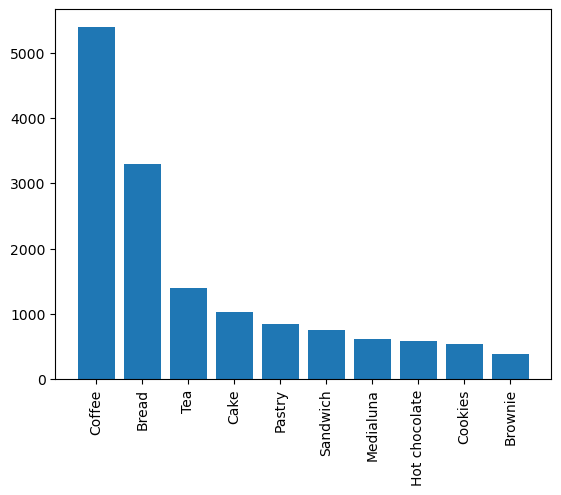

In [451]:
# print("Num transactions:", len(dataset))
freq = {}
for i in range(len(dataset)-1, 0, -1): 
    for item in dataset[i] : 
        if 'NONE' in dataset[i] :
            dataset[i].remove('NONE')
        freq[item] = 1 if item not in freq else freq[item] + 1
    if (len(dataset[i]) == 0) :
        dataset.remove(dataset[i])

sorted_freq = dict(sorted(freq.items(), key = lambda item: item[1], reverse=True))

top_ten = list(sorted_freq)[:10]
sorted_top_ten_val = []
for i in top_ten : 
    sorted_top_ten_val.append(sorted_freq[i])
plt.bar(top_ten, sorted_top_ten_val)
plt.xticks(rotation='vertical')


Q9. 

a.) Using `mlxtend.preprocessing.TransactionEncoder`, transform `dataset` into an array format suitable for the `mlxtend` library. You will need to call `fit` then `transform`. 

`TransactionEncoder` learns unique items from the dataset and transforms each transaction into a one-hot encoded boolean numpy array. For example, the resulting encoded dataset will be represented by something like this, where each row is a transaction. If the first transaction contained ['Crepe', 'Jam'], this would correspond to the first row in the encoded table. 

<img src="table.png">

Print the `shape` of the resulting encoded numpy array.

b.) `TransactionEncoder` also has a function `inverse_transform` that allows you to tranform one-hot encoded transactions back to the item labels. Try it out on the first 5 transactions and display the items in the first 5 transactions.

In [452]:
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
print("nparray shape: ", te_ary.shape)
# We successfully got a numpy array

subs = te_ary[:5]
inv = te.inverse_transform(subs)
print(inv)
# It appears as if the function worked.

nparray shape:  (9466, 95)
[['Bread'], ['Scandinavian'], ['Cookies', 'Hot chocolate', 'Jam'], ['Muffin'], ['Bread', 'Coffee', 'Pastry']]


Q10. Convert the encoded numpy array from the previous question (part a) into a pandas dataframe. Use the `TransactionEncoder`'s `.columns_` attribute as the column headers. Print the head of the resulting dataframe. 

In [453]:
import pandas as pd
df = pd.DataFrame(te_ary, columns=te.columns_)
df.head()

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Q11. Use the `mlxtend.frequent_patterns.apriori` to generate the frequent itemsets with minimum support of 1% (0.01). Display these itemsets along with their support values.

In [454]:
freq_items_apr = apriori(df, min_support=0.01, use_colnames=True)

Q12. Use `mlxtend.frequent_patterns.fpmax` to find and display all of the maximal frequent itemsets along with their support values. 

In [455]:
freq_items_fpm = fpmax(df, min_support=0.01, use_colnames=True)


Q13. Use `mlxtend.frequent_patterns.association_rules` to calculate rules with a confidence level of 0.25 for the frequent itemsets you generated in Q11.

In [456]:
association_rules(freq_items_apr, metric="confidence", min_threshold=0.25)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Alfajores),(Bread),0.036341,0.327171,0.010353,0.284884,0.870749,-0.001537,0.940867,-0.133475
1,(Alfajores),(Coffee),0.036341,0.478344,0.019649,0.540698,1.130354,0.002266,1.135758,0.119671
2,(Brownie),(Bread),0.040038,0.327171,0.010775,0.269129,0.822595,-0.002324,0.920586,-0.183446
3,(Bread),(Coffee),0.327171,0.478344,0.090006,0.275105,0.575120,-0.066494,0.719630,-0.523356
4,(Cookies),(Bread),0.054405,0.327171,0.014473,0.266019,0.813090,-0.003327,0.916685,-0.195561
5,(Medialuna),(Bread),0.061800,0.327171,0.016903,0.273504,0.835968,-0.003317,0.926129,-0.172969
6,(Pastry),(Bread),0.086098,0.327171,0.029157,0.338650,1.035087,0.000988,1.017358,0.037091
7,(Brownie),(Coffee),0.040038,0.478344,0.019649,0.490765,1.025968,0.000497,1.024393,0.026366
8,(Cake),(Coffee),0.103845,0.478344,0.054722,0.526958,1.101631,0.005048,1.102771,0.102946
9,(Cookies),(Coffee),0.054405,0.478344,0.028206,0.518447,1.083837,0.002182,1.083279,0.081803


Q14. An important step in generating a set of association rules is to determine the optimal thresholds for support and confidence. If we set these values too low we will get a lot of rules and most of them will not be useful. 

Generate the frequent itemsets with minimum support of 0.5% and plot the number of rules generated with respect to the confidence threshold by varying min_conf between 0 and 1 with increments of 0.1. Notice what happens when you increase the confidence level.

Text(0.5, 1.0, 'Number of Itemsets vs Min Confidence')

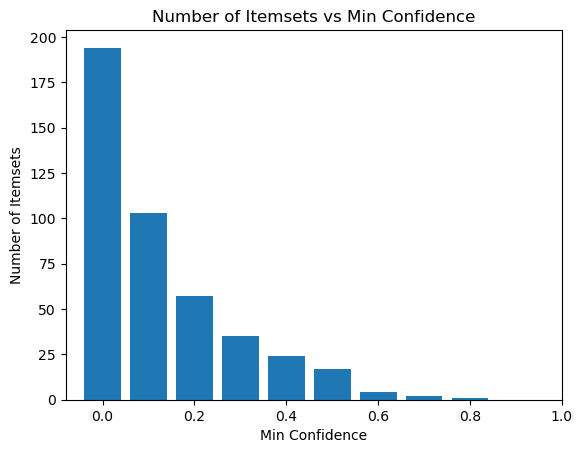

In [457]:
rules = []
conf = []
for cf in range(0, 11, 1) :
    cf = cf / 10
    freq_items_apr = apriori(df, min_support=0.005, use_colnames=True)
    ac = association_rules(freq_items_apr, metric="confidence", min_threshold=cf)
    rules.append(len(ac))
    conf.append(cf)

plt.bar(conf, rules, width=0.08)
plt.xlabel('Min Confidence')
plt.xlim(-0.08, 1)

plt.ylabel('Number of Itemsets')
plt.title('Number of Itemsets vs Min Confidence')    

Q15. What value would you choose for the minimum confidence threshold based on the previous plot? Explain why as a comment. 

Display the rules generated for the your chosen value. Take a look at the generated rules. Are they interesting? As a comment, explain why or why not.

In [458]:
'''
   We would choose where the the number of itemset generalizations begins to see diminishing returns, so about at minconf = 0.3
   We do not want to have too many transactions to hone in pricing deals on, but we also don't want to limit it so much that
   barely anything is displayed (such as at 0.8). In other words, we want a strong correlation between X and Y, but no so strong
   that none of the transactions meet the threshold. 
'''

freq_items_apr = apriori(df, min_support=0.005, use_colnames=True)
ac = association_rules(freq_items_apr, metric="confidence", min_threshold=0.3)
print(ac)

'''
   - It seems like coffee is often a consequent of a purchase. This makes sense as it was the highest frequency item in the dataset.
   - Oftentimes, poeple purchase a pastry (such as Cake or Cookies) with Coffee. Good combo!
   - Garbage In Garbage Out: there are a few items that lack context, such as 'Keeping It Local' with a support count of 0.006
   
'''


               antecedents consequents  antecedent support  \
0              (Alfajores)    (Coffee)            0.036341   
1                    (Jam)     (Bread)            0.015001   
2                 (Pastry)     (Bread)            0.086098   
3                (Brownie)    (Coffee)            0.040038   
4                   (Cake)    (Coffee)            0.103845   
5           (Chicken Stew)    (Coffee)            0.012994   
6                   (Coke)    (Coffee)            0.019438   
7                (Cookies)    (Coffee)            0.054405   
8      (Hearty & Seasonal)    (Coffee)            0.010564   
9          (Hot chocolate)    (Coffee)            0.058314   
10        (Jammie Dodgers)    (Coffee)            0.013205   
11                 (Juice)    (Coffee)            0.038559   
12      (Keeping It Local)    (Coffee)            0.006655   
13             (Medialuna)    (Coffee)            0.061800   
14         (Mineral water)    (Coffee)            0.014156   
15      

"\n   - It seems like coffee is often a consequent of a purchase. This makes sense as it was the highest frequency item in the dataset.\n   - Oftentimes, poeple purchase a pastry (such as Cake or Cookies) with Coffee. Good combo!\n   - Garbage In Garbage Out: there are a few items that lack context, such as 'Keeping It Local' with a support count of 0.006\n   \n"